In [1]:
import numpy as np # linear algebra
import os  # accessing directory structure
import matplotlib # visualization
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage # image processing
from skimage.measure import regionprops # image processing
from skimage import io # image processing
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf # deep learning
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from time import time # for timing
import keras # deep learning

d:\Arpit College\FYP\SignatureVerificationSystem\sigverfiyenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Arpit College\FYP\SignatureVerificationSystem\sigverfiyenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Arpit College\FYP\SignatureVerificationSystem\sigverfiyenv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [2]:
genuine_image_paths = "D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\real/"
forged_image_paths = "D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\forged/"



In [3]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [4]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [5]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        print("RGB Image")
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        print("Greyscale Image")
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        print("Binary Image")
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now this will make a bounding box with the boundary as the position of pixels on extreme.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        print("Cropped Image")
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

In [6]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [7]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [8]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [9]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [10]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [11]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

## Saving the features

In [12]:
def makeCSV():
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features')
        print('New folder "Features" created')
        
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Training')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Training')
        print('New folder "Features/Training" created')

    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Testing')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,15):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,3):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,3):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')
        
        with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(3,5):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

In [13]:
makeCSV()

Saving features for person id- 001


KeyboardInterrupt: 

# TF Model 

In [14]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures')
    with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [17]:
n_input = 9
train_person_id = input("Enter person's id : ")
test_image_path = input("Enter path of signature image : ")
train_path = 'D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Training/training_'+train_person_id+'.csv'
testing(test_image_path)
test_path = 'D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures/testcsv.csv'

def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=range(n_input))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = keras.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

tf.reset_default_graph()
# Parameters
learning_rate = 0.001
training_epochs = 10000
display_step = 1


# Network Parameters
n_hidden_1 = 7 # 1st layer number of neurons
n_hidden_2 = 7 # 2nd layer number of neurons
n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],seed=2)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], seed=2)),
    'out': tf.Variable(tf.random_normal([n_classes], seed=1))
}


# Create model
def multilayer_perceptron(x):
    layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    out_layer = tf.tanh(tf.matmul(layer_2, weights['out']) + biases['out'])
    return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer

loss_op = tf.reduce_mean(tf.squared_difference(logits, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# For accuracies
pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

def evaluate(train_path, test_path, type2=False):   
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    costs=[]

    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):

            # Run optimization op (backprop) and cost op (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            costs.append(cost)

            if epoch%100==0:
                print(epoch , cost)
            elif epoch==training_epochs-1:
                print(epoch , cost)

            if cost<0.0001:
                break
        print("Optimization Finished!")

         # Plot the cost values
        plt.plot(costs)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost vs. Epoch')
        plt.show()


        # Finding accuracies
        accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
        print("Accuracy for train:", accuracy1)
        
        if type2 is False:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})   

            return accuracy1, accuracy2
            
        else:
            prediction = pred.eval({X: test_input})
            # import pdb; pdb.set_trace()
            if prediction[0][1]>prediction[0][0]:
                print('Genuine Image')
                return True
            else:
                print('Forged Image')
                return False


def trainAndTest(rate=0.001, epochs=10000, neurons=7, display=False):    
    start = time()

    # Parameters
    global training_rate, training_epochs, n_hidden_1
    learning_rate = rate
    training_epochs = epochs

    # Network Parameters
    n_hidden_1 = neurons # 1st layer number of neurons
    n_hidden_2 = 7 # 2nd layer number of neurons

    train_avg, test_avg = 0, 0
    n = 14
    for i in range(1,n+1):
        if display:
            print("Running for Person id",i)
        temp = ('0'+str(i))[-2:]
        train_score, test_score = evaluate(train_path.replace('01',temp), test_path.replace('01',temp))
        train_avg += train_score
        test_avg += test_score
    if display:
        print("Number of neurons in Hidden layer-", n_hidden_1)
        print("Number of neurons in Hidden layer-", n_hidden_2)
        print("Training average-", train_avg/n)
        print("Testing average-", test_avg/n)
        print("Time taken-", time()-start)
        print("Learning rate- ", learning_rate)
    return train_avg/n, test_avg/n, (time()-start)/n

# trainAndTest(display=True)




0 2.449459
100 1.8519497
200 0.087936155
300 0.05707724
400 0.04008663
500 0.0249507
600 0.011530268
700 0.0046951273
800 0.0022730755
900 0.0013378779
1000 0.0009055163
1100 0.00067037105
1200 0.000525813
1300 0.0004286481
1400 0.0003589467
1500 0.0003064881
1600 0.00026555426
1700 0.00023272146
1800 0.00020579931
1900 0.0001833379
2000 0.00016433245
2100 0.00014805763
2200 0.00013398765
2300 0.00012171562
2400 0.00011093879
2500 0.000101414975
Optimization Finished!


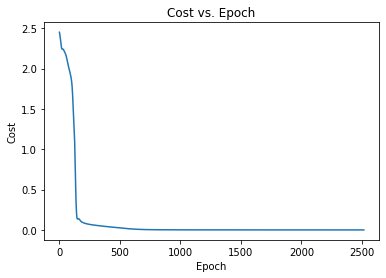

Accuracy for train: 1.0
> <ipython-input-17-2ef0e2fbbd94>(128)evaluate()
    126             prediction = pred.eval({X: test_input})
    127             import pdb; pdb.set_trace()
--> 128             if prediction[0][1]>prediction[0][0]:
    129                 print('Genuine Image')
    130                 return True

[[0.73087275 0.26912722]]
0.26912722
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
0.73087275
*** SyntaxError: invalid syntax
Forged Image


False

In [18]:
evaluate(train_path, test_path, type2=True)

Running for Person id 1
0 2.4635847
100 0.7893273
200 0.18822591
300 0.091823764
400 0.033109408
500 0.018366998
600 0.012254977
700 0.009126217
800 0.007295709
900 0.0061475914
1000 0.0053804126
1100 0.0048231874
1200 0.0043805926
1300 0.0040028165
1400 0.0036639338
1500 0.0033495538
1600 0.0030507185
1700 0.002761523
1800 0.002477916
1900 0.0021979043
2000 0.0019217529
2100 0.0016525717
2200 0.0013961584
2300 0.0011599174
2400 0.0009507753
2500 0.00077296415
2600 0.000627076
2700 0.000510471
2800 0.00041873904
2900 0.00034701338
3000 0.0002908428
3100 0.0002465605
3200 0.00021130266
3300 0.00018290729
3400 0.00015975964
3500 0.0001406711
3600 0.00012474836
3700 0.000111325586
3800 9.990035e-05
Optimization Finished!


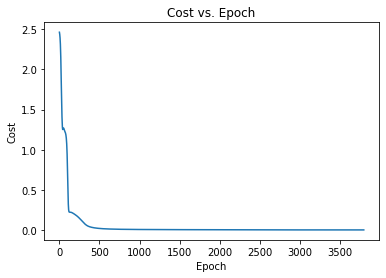

Accuracy for train: 1.0
Running for Person id 2
0 1.4651717
100 1.3865963
200 0.2605637
300 0.25296426
400 0.24509716
500 0.22541861
600 0.1888302
700 0.14512052
800 0.08955497
900 0.057237606
1000 0.04241863
1100 0.032034025
1200 0.024274379
1300 0.018577421
1400 0.0143499775
1500 0.011122711
1600 0.008609506
1700 0.006655302
1800 0.0051602586
1900 0.004039517
2000 0.0032056503
2100 0.0025848802
2200 0.0021197486
2300 0.0017660479
2400 0.0014925854
2500 0.0012786841
2600 0.001109085
2700 0.00096934213
2800 0.0008558589
2900 0.0007660641
3000 0.000682076
3100 0.00061445567
3200 0.00058931095
3300 0.0005063515
3400 0.0004627372
3500 0.0004249957
3600 0.00039049293
3700 0.00036045955
3800 0.0003423223
3900 0.00030960882
4000 0.00031179804
4100 0.00026843874
4200 0.00025050048
4300 0.00023444835
4400 0.00021949796
4500 0.00020591448
4600 0.00020510946
4700 0.00018188621
4800 0.00017173133
4900 0.00016138186
5000 0.00015235184
5100 0.00014385984
5200 0.00013614597
5300 0.00012880132
5400 0

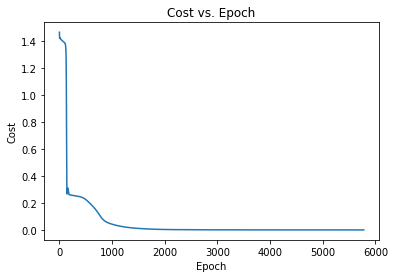

Accuracy for train: 1.0
Running for Person id 3
0 1.9695158
100 1.3173176
200 0.14807914
300 0.12506092
400 0.102827854
500 0.09365208
600 0.08950368
700 0.087310135
800 0.08600556
900 0.08515691
1000 0.084574156
1100 0.08416128
1200 0.08386118
1300 0.083636016
1400 0.0834598
1500 0.08331438
1600 0.08318656
1700 0.08306602
1800 0.082943134
1900 0.08280743
2000 0.082644425
2100 0.08243082
2200 0.08212262
2300 0.08162301
2400 0.08067446
2500 0.07837931
2600 0.070366584
2700 0.03716173
2800 0.0044631385
2900 0.0011507064
3000 0.00056734844
3100 0.0003560886
3200 0.00025126294
3300 0.00018982751
3400 0.00014993982
3500 0.00012218599
3600 0.00010189315
Optimization Finished!


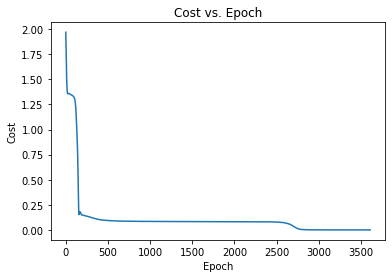

Accuracy for train: 1.0
Running for Person id 4
0 2.449459
100 1.8519497
200 0.087936155
300 0.05707724
400 0.04008663
500 0.0249507
600 0.011530268
700 0.0046951273
800 0.0022730755
900 0.0013378779
1000 0.0009055163
1100 0.00067037105
1200 0.000525813
1300 0.0004286481
1400 0.0003589467
1500 0.0003064881
1600 0.00026555426
1700 0.00023272146
1800 0.00020579931
1900 0.0001833379
2000 0.00016433245
2100 0.00014805763
2200 0.00013398765
2300 0.00012171562
2400 0.00011093879
2500 0.000101414975
Optimization Finished!


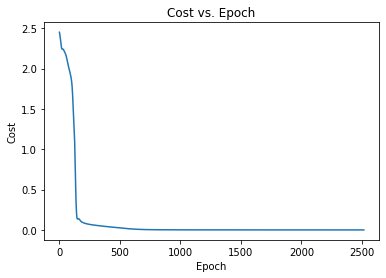

Accuracy for train: 1.0
Running for Person id 5
0 2.131748
100 1.3815321
200 0.2642394
300 0.22061817
400 0.07505164
500 0.029119177
600 0.014905113
700 0.008236654
800 0.004746768
900 0.0028404545
1000 0.0017839236
1100 0.0011980933
1200 0.00086720084
1300 0.00066808803
1400 0.00053723936
1500 0.0004443092
1600 0.00037448911
1700 0.00031999664
1800 0.00027635883
1900 0.0002407593
2000 0.00021130302
2100 0.00018664626
2200 0.00016580003
2300 0.00014802004
2400 0.00013273834
2500 0.00011951061
2600 0.00010798831
Optimization Finished!


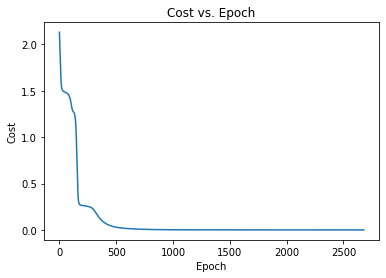

Accuracy for train: 1.0
Running for Person id 6
0 2.4797652
100 1.3582317
200 0.25418505
300 0.1828466
400 0.16563447
500 0.15233557
600 0.1392697
700 0.124726176
800 0.109352164
900 0.099666744
1000 0.09516671
1100 0.0924626
1200 0.0904808
1300 0.088923484
1400 0.08768827
1500 0.08672023
1600 0.08597352
1700 0.08540469
1800 0.08497412
1900 0.084648125
2000 0.08439993
2100 0.0842093
2200 0.08406124
2300 0.08394482
2400 0.083852135
2500 0.08377748
2600 0.08371664
2700 0.083666556
2800 0.08362493
2900 0.08358996
3000 0.0835604
3100 0.083535194
3200 0.08351361
3300 0.08349491
3400 0.08347868
3500 0.0834645
3600 0.08345207
3700 0.08344111
3800 0.08343139
3900 0.08342276
4000 0.08341509
4100 0.083408214
4200 0.08340201
4300 0.083396435
4400 0.083391435
4500 0.083387166
4600 0.08338285
4700 0.08337924
4800 0.08337582
4900 0.083372824
5000 0.08337006
5100 0.08336756
5200 0.08336524
5300 0.08336312
5400 0.08336138
5500 0.08335947
5600 0.08335783
5700 0.08335641
5800 0.08335505
5900 0.083353855

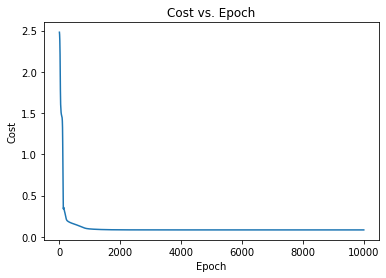

Accuracy for train: 0.8333333
Running for Person id 7
0 2.4771848
100 1.0428525
200 0.31432015
300 0.20976566
400 0.17638506
500 0.16707689
600 0.1605952
700 0.154427
800 0.14748076
900 0.13993843
1000 0.13211563
1100 0.12414196
1200 0.11593425
1300 0.10727521
1400 0.09792954
1500 0.087716945
1600 0.076552205
1700 0.064386025
1800 0.05093575
1900 0.03625572
2000 0.02376918
2100 0.015585352
2200 0.010408256
2300 0.0071515306
2400 0.005093236
2500 0.003762112
2600 0.002872141
2700 0.0022555115
2800 0.0018135797
2900 0.0014872802
3000 0.0012419212
3100 0.0010529798
3200 0.00090442336
3300 0.0007850919
3400 0.0006877291
3500 0.0006071666
3600 0.0005397551
3700 0.00048287542
3800 0.00043441702
3900 0.00039292406
4000 0.00035624582
4100 0.00032471525
4200 0.00029661742
4300 0.0002719842
4400 0.00025121422
4500 0.00023052585
4600 0.00021527246
4700 0.00019711627
4800 0.00018292353
4900 0.00016994205
5000 0.00015812574
5100 0.0001474145
5200 0.0001375456
5300 0.00012859101
5400 0.00012167343
5

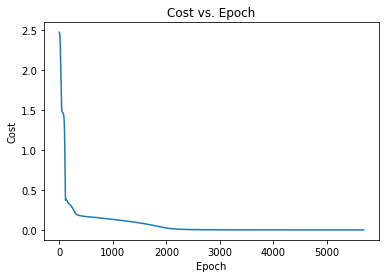

Accuracy for train: 1.0
Running for Person id 8
0 2.4947135
100 1.1598359
200 0.19503231
300 0.16298251
400 0.15484826
500 0.15193556
600 0.15002812
700 0.14828527
800 0.14631541
900 0.14371894
1000 0.13974369
1100 0.13269848
1200 0.11954235
1300 0.09671635
1400 0.06799266
1500 0.04577392
1600 0.031806827
1700 0.023430577
1800 0.018314904
1900 0.0149783
2000 0.012614898
2100 0.010810393
2200 0.009349481
2300 0.008116634
2400 0.007047884
2500 0.006106952
2600 0.0052731927
2700 0.0045343894
2800 0.00388233
2900 0.0033110569
3000 0.0028147215
3100 0.0023874012
3200 0.0020227118
3300 0.0017139573
3400 0.0014543384
3500 0.0012372272
3600 0.0010579085
3700 0.00090977945
3800 0.0007870877
3900 0.0006851599
4000 0.00059978734
4100 0.0005297369
4200 0.00046743196
4300 0.0004157327
4400 0.00037182448
4500 0.00033348124
4600 0.00030062892
4700 0.00027280688
4800 0.0002469512
4900 0.0002252385
5000 0.00020594108
5100 0.00018873747
5200 0.00017393113
5300 0.00016037708
5400 0.00014856303
5500 0.000

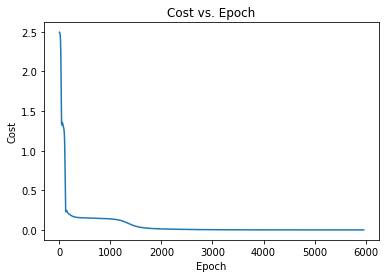

Accuracy for train: 1.0
Running for Person id 9
0 2.4976826
100 0.83737254
200 0.21870585
300 0.16380998
400 0.14452548
500 0.1293822
600 0.11406777
700 0.09353917
800 0.07729574
900 0.06523067
1000 0.05529635
1100 0.046509653
1200 0.038512796
1300 0.031237846
1400 0.024786806
1500 0.019302825
1600 0.014853862
1700 0.011388797
1800 0.008766512
1900 0.006814655
2000 0.0053764745
2100 0.0043100766
2200 0.0035106593
2300 0.0029031003
2400 0.0024320476
2500 0.0020704882
2600 0.0017681769
2700 0.0015308507
2800 0.0013396685
2900 0.0011755099
3000 0.0010409747
3100 0.0009299169
3200 0.000830386
3300 0.0007472208
3400 0.0006751593
3500 0.0006125073
3600 0.0005582513
3700 0.0005089643
3800 0.00046618597
3900 0.00044006118
4000 0.00039381845
4100 0.00036318647
4200 0.00033566987
4300 0.00031316388
4400 0.0002881508
4500 0.00026780344
4600 0.00024909503
4700 0.00023217073
4800 0.00021710015
4900 0.00020238485
5000 0.00022718764
5100 0.00017732898
5200 0.00020193978
5300 0.0001560562
5400 0.00014

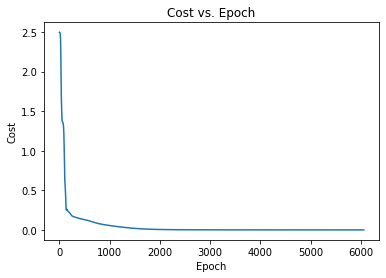

Accuracy for train: 1.0
Running for Person id 10
0 1.8221245
100 1.4265445
200 0.2849778
300 0.18179417
400 0.065605976
500 0.040252034
600 0.02858273
700 0.020357644
800 0.015377325
900 0.012600715
1000 0.010784651
1100 0.00941547
1200 0.0083056735
1300 0.007369563
1400 0.0065633655
1500 0.0058621024
1600 0.0052491077
1700 0.004711391
1800 0.0042382474
1900 0.0038203828
2000 0.0034499608
2100 0.0031201022
2200 0.0028249435
2300 0.0025594926
2400 0.0023194496
2500 0.0021012758
2600 0.0019019833
2700 0.0017190288
2800 0.001550486
2900 0.0013946673
3000 0.0012503499
3100 0.0011166261
3200 0.0009927956
3300 0.00087846426
3400 0.00077333447
3500 0.00067728455
3600 0.0005901602
3700 0.0005118469
3800 0.0004420624
3900 0.00038048287
4000 0.00032660319
4100 0.0002798531
4200 0.00023957515
4300 0.00020505239
4400 0.00017646053
4500 0.00015064246
4600 0.00012970266
4700 0.00011173874
Optimization Finished!


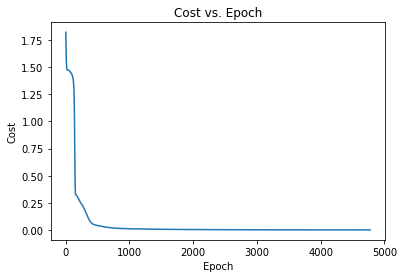

Accuracy for train: 1.0
Running for Person id 11
0 2.4123206
100 1.3285486
200 1.2542331
300 1.2415375
400 0.36333513
500 0.13568912
600 0.11918547
700 0.09923414
800 0.07262085
900 0.044745535
1000 0.024131475
1100 0.012540516
1200 0.007062029
1300 0.00447782
1400 0.003108329
1500 0.0022911362
1600 0.0017608391
1700 0.0013957733
1800 0.0011331482
1900 0.00093757286
2000 0.00078783097
2100 0.0006705233
2200 0.00057685404
2300 0.0005008311
2400 0.00043825957
2500 0.00038613347
2600 0.00034224798
2700 0.0003049568
2800 0.00027300173
2900 0.00024541552
3000 0.00022144685
3100 0.0002004933
3200 0.00018207928
3300 0.00016581343
3400 0.00015138413
3500 0.00013853076
3600 0.00012703676
3700 0.00011672409
3800 0.00010744302
Optimization Finished!


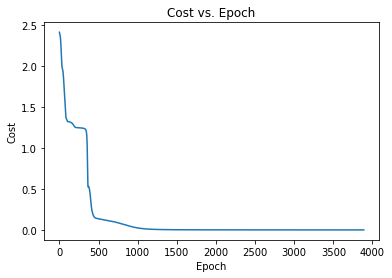

Accuracy for train: 1.0
Running for Person id 12
0 1.9943237
100 1.4207293
200 0.28042665
300 0.23671527
400 0.093794525
500 0.06464896
600 0.048735905
700 0.035558227
800 0.024444193
900 0.016361922
1000 0.011372772
1100 0.008383883
1200 0.006430944
1300 0.0050381008
1400 0.0039881286
1500 0.0031710423
1600 0.0025256628
1700 0.0020143527
1800 0.0016113194
1900 0.0012964272
2000 0.0010524481
2100 0.0008641787
2200 0.0007185461
2300 0.000604968
2400 0.00051531784
2500 0.00044358638
2600 0.00038540605
2700 0.00033759917
2800 0.0002978493
2900 0.00026443193
3000 0.00023606962
3100 0.00021177798
3200 0.00019081391
3300 0.00017258823
3400 0.00015664462
3500 0.00014261743
3600 0.00013020901
3700 0.00011918213
3800 0.00010934022
3900 0.00010052221
Optimization Finished!


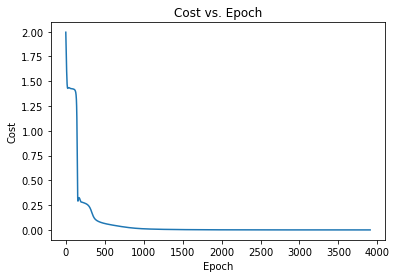

Accuracy for train: 1.0
Running for Person id 13
0 2.3795764
100 1.299964
200 0.08330999
300 0.062124323
400 0.037215818
500 0.022617208
600 0.017422264
700 0.013791745
800 0.010997958
900 0.008731894
1000 0.0069433204
1100 0.0056078327
1200 0.004620095
1300 0.0038545998
1400 0.0032269333
1500 0.0026948706
1600 0.0022388196
1700 0.001849046
1800 0.0015191175
1900 0.0012435162
2000 0.0010163158
2100 0.0008312512
2200 0.00068195147
2300 0.0005621838
2400 0.0004663903
2500 0.0003897342
2600 0.00032820122
2700 0.00027856196
2800 0.00023825432
2900 0.00020529419
3000 0.00017812573
3100 0.00015556441
3200 0.00013667792
3300 0.000120751116
3400 0.000107221225
Optimization Finished!


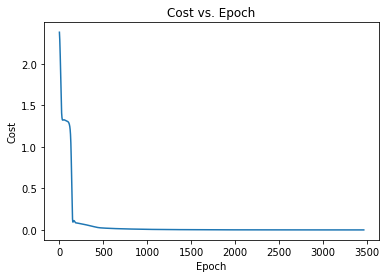

Accuracy for train: 1.0
Running for Person id 14
0 2.4682539
100 1.3277005
200 0.25241792
300 0.2362644
400 0.21728356
500 0.18298297
600 0.15228826
700 0.13088691
800 0.11810606
900 0.10816277
1000 0.09991837
1100 0.092966676
1200 0.08677215
1300 0.08087299
1400 0.075005956
1500 0.06907127
1600 0.06304186
1700 0.056888524
1800 0.050548762
1900 0.043927204
2000 0.036779698
2100 0.02727636
2200 0.018619262
2300 0.012976841
2400 0.009189983
2500 0.00668955
2600 0.005009884
2700 0.0038461972
2800 0.0030165194
2900 0.0024105434
3000 0.0019585507
3100 0.0016174145
3200 0.0013557328
3300 0.0011510022
3400 0.0009878193
3500 0.00085615803
3600 0.00074855797
3700 0.0006594613
3800 0.0005846945
3900 0.00052150193
4000 0.00046738648
4100 0.00042100795
4200 0.00038339745
4300 0.00034565385
4400 0.0003149477
4500 0.00028774273
4600 0.0002637635
4700 0.00024250754
4800 0.00022320224
4900 0.00020708895
5000 0.00019064893
5100 0.00017831362
5200 0.00016407412
5300 0.00015301611
5400 0.00014304044
5500

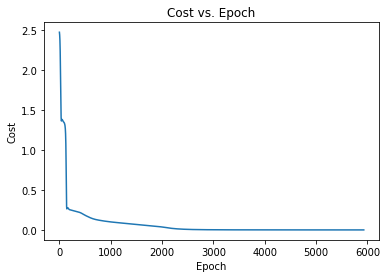

Accuracy for train: 1.0
Number of neurons in Hidden layer- 7
Number of neurons in Hidden layer- 7
Training average- 0.9880952366760799
Testing average- 0.5
Time taken- 52.43410539627075
Learning rate-  0.001


(0.9880952366760799, 0.5, 3.745293242590768)

In [34]:
trainAndTest(display=True)